<a href="https://colab.research.google.com/github/yeonkkk/AIFFEL-Project/blob/main/AIFFEL-Project/Exploration12/project/%5BE_12%5DPredict_Next_Movie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# E-12. Predict Next Movie

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [5]:
data_path = '/content/drive/MyDrive/ex12/ml-1m/'
train_path = data_path + '/' +'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data


In [6]:
data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 31 to 1000042
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   UserId  1000209 non-null  int32
 1   ItemId  1000209 non-null  int32
 2   Rating  1000209 non-null  int32
 3   Time    1000209 non-null  int64
dtypes: int32(3), int64(1)
memory usage: 26.7 MB


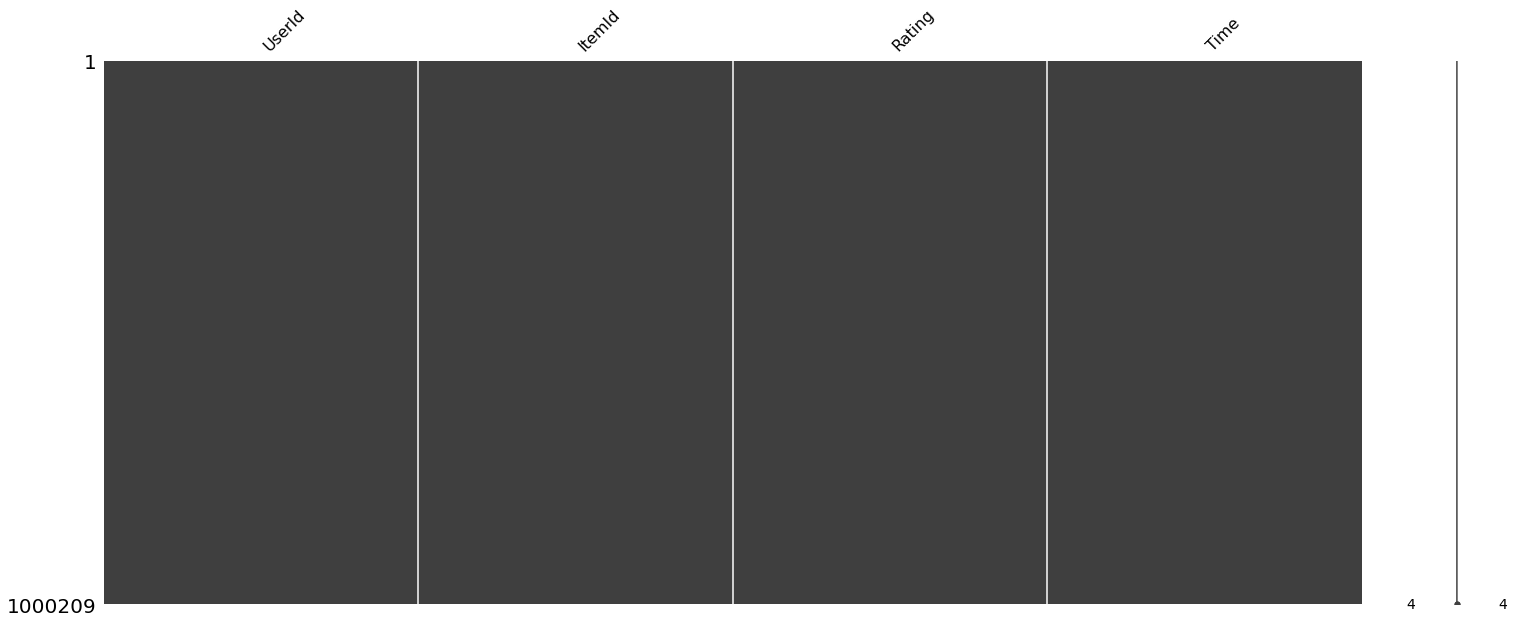

In [8]:
import missingno as msno
msno.matrix(data)

In [9]:
# 유저수, 아이템 수
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [10]:
# 유저별 리뷰 수
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [11]:
# 중앙값
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [12]:


# 최소, 최댓값
session_length.min(), session_length.max()

(20, 2314)

In [13]:
# 분위수
session_length.quantile(0.999)

1343.181000000005

In [14]:
# 최다 리뷰자 확인
long_session = session_length[session_length==2314].index[0]
data[data['UserId']==long_session].head(30)

,UserId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
696168,4169,3801,5,965333481
696250,4169,3841,2,965333481
697903,4169,3761,3,965333481
697954,4169,3788,3,965333481
695653,4169,3794,4,965333519


- 최다 리뷰자의 리뷰 시간을 보면 동일한 시간에 여러 영화를 리뷰한 것을 확인할 수 있다.

In [15]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

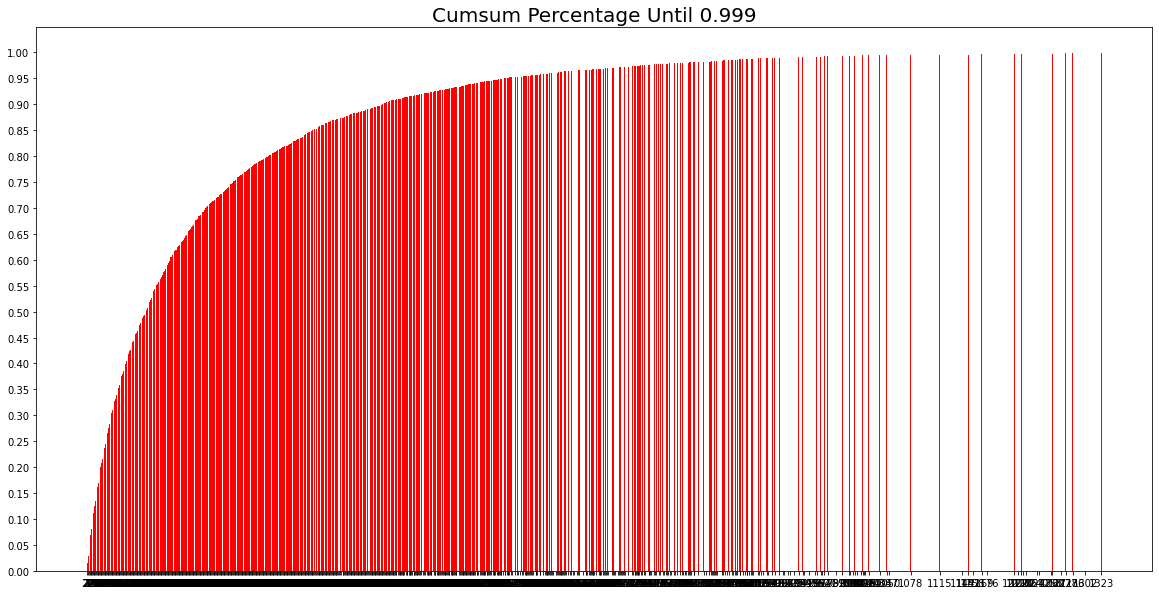

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [17]:
count_rating = data.groupby('Rating').count()
count_rating

,UserId,ItemId,Time
Rating,,,
1,56174,56174,56174
2,107557,107557,107557
3,261197,261197,261197
4,348971,348971,348971
5,226310,226310,226310


- 평점별 데이터량을 확인해보았다.
- 평점이 너무 낮은 데이터는 삭제한다.
- 1점과 2점의 데이터 양이 상대적으로 많지 않아 삭제하도록 한다.

In [18]:
data = data[data['Rating']>=3]
print(len(data))

836478


#### Session Time


In [19]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

956703932
1046454590


In [20]:
print(dt.datetime.utcfromtimestamp(oldest).strftime('%Y-%m-%d %H:%M:%S'))
print(dt.datetime.utcfromtimestamp(latest).strftime('%Y-%m-%d %H:%M:%S'))

2000-04-25 23:05:32
2003-02-28 17:49:50


In [21]:
from datetime import datetime

change_date = []
for time in data['Time']:
    temp = dt.datetime.fromtimestamp(time)
    change_date.append(temp)

data['Time'] = change_date
data.head()

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43


### Data Cleansing

In [22]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [23]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


## Train/ Valid/ Test split

In [24]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('Time')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['Time'].isin(session_in_train)]
    after_date = data[data['Time'].isin(session_in_test)]
    return before_date, after_date

In [25]:
tr, test = split_by_date(data, n_days=180)
tr, val = split_by_date(tr, n_days=180)

In [26]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [27]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 818736
	 Sessions: 6036
	 Items: 3307
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-03-05 04:14:13

* valid Set Stats Info
	 Events: 9771
	 Sessions: 390
	 Items: 2348
	 First Time : 2002-03-05 04:24:20
	 Last Time : 2002-09-01 04:20:59

* test Set Stats Info
	 Events: 7282
	 Sessions: 333
	 Items: 2049
	 First Time : 2002-09-01 19:41:39
	 Last Time : 2003-02-28 17:49:50



In [28]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [38]:
tr.to_pickle('/content/drive/MyDrive/ex12/ml-1m/processed/train.pkl')
val.to_pickle('/content/drive/MyDrive/ex12/ml-1m/processed/valid.pkl')
test.to_pickle('/content/drive/MyDrive/ex12/ml-1m/processed/test.pkl')

In [40]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [41]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [42]:
tr_dataset.click_offsets

array([     0,     53,    169, ..., 818341, 818460, 818736], dtype=int32)

In [43]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 6033, 6034, 6035])

In [44]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [59]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=1)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [60]:
iter_ex = iter(tr_data_loader)

In [61]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [0]
Label Item Idx are :       [1]
Previous Masked Input Idx are []


In [62]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [63]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [64]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [68]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [76]:
args2 = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [80]:
args3 = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=15, k=20)

In [84]:
args4 = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=15, k=30)

In [69]:
model = create_model(args)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(256, 1, 3307)]          0         
                                                                 
 GRU (GRU)                   [(256, 50),               503850    
                              (256, 50)]                         
                                                                 
 dropout_2 (Dropout)         (256, 50)                 0         
                                                                 
 dense_2 (Dense)             (256, 3307)               168657    
                                                                 
Total params: 672,507
Trainable params: 672,507
Non-trainable params: 0
_________________________________________________________________


In [77]:
model2 = create_model(args2)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(256, 1, 3307)]          0         
                                                                 
 GRU (GRU)                   [(256, 50),               503850    
                              (256, 50)]                         
                                                                 
 dropout_4 (Dropout)         (256, 50)                 0         
                                                                 
 dense_4 (Dense)             (256, 3307)               168657    
                                                                 
Total params: 672,507
Trainable params: 672,507
Non-trainable params: 0
_________________________________________________________________


In [81]:
model3 = create_model(args3)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(256, 1, 3307)]          0         
                                                                 
 GRU (GRU)                   [(256, 50),               503850    
                              (256, 50)]                         
                                                                 
 dropout_5 (Dropout)         (256, 50)                 0         
                                                                 
 dense_5 (Dense)             (256, 3307)               168657    
                                                                 
Total params: 672,507
Trainable params: 672,507
Non-trainable params: 0
_________________________________________________________________


In [85]:
model4 = create_model(args4)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(256, 1, 3307)]          0         
                                                                 
 GRU (GRU)                   [(256, 50),               503850    
                              (256, 50)]                         
                                                                 
 dropout_6 (Dropout)         (256, 50)                 0         
                                                                 
 dense_6 (Dense)             (256, 3307)               168657    
                                                                 
Total params: 672,507
Trainable params: 672,507
Non-trainable params: 0
_________________________________________________________________


In [70]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

#### 1차 시도

In [71]:
train_model(model, args)

Evaluation:  14%|█▍        | 5/36 [00:08<00:52,  1.70s/it]


	 - Recall@20 epoch 1: 0.061719
	 - MRR@20    epoch 1: 0.015618



Evaluation:  14%|█▍        | 5/36 [00:07<00:45,  1.48s/it]


	 - Recall@20 epoch 2: 0.097656
	 - MRR@20    epoch 2: 0.026236



Evaluation:  14%|█▍        | 5/36 [00:07<00:45,  1.48s/it]

	 - Recall@20 epoch 3: 0.104688
	 - MRR@20    epoch 3: 0.030957



In [72]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:   7%|▋         | 2/27 [00:03<00:38,  1.54s/it]

	 - Recall@20: 0.113281
	 - MRR@20: 0.029168



#### 2차 시도

In [78]:
train_model(model2, args2)

Evaluation:  14%|█▍        | 5/36 [00:08<00:50,  1.62s/it]


	 - Recall@20 epoch 1: 0.060156
	 - MRR@20    epoch 1: 0.013704



Evaluation:  14%|█▍        | 5/36 [00:07<00:46,  1.49s/it]


	 - Recall@20 epoch 2: 0.093750
	 - MRR@20    epoch 2: 0.026281



Evaluation:  14%|█▍        | 5/36 [00:07<00:46,  1.50s/it]


	 - Recall@20 epoch 3: 0.103906
	 - MRR@20    epoch 3: 0.029229



Evaluation:  14%|█▍        | 5/36 [00:07<00:45,  1.47s/it]


	 - Recall@20 epoch 4: 0.103906
	 - MRR@20    epoch 4: 0.033319



Evaluation:  14%|█▍        | 5/36 [00:07<00:47,  1.52s/it]


	 - Recall@20 epoch 5: 0.108594
	 - MRR@20    epoch 5: 0.034461



Evaluation:  14%|█▍        | 5/36 [00:07<00:46,  1.49s/it]


	 - Recall@20 epoch 6: 0.107031
	 - MRR@20    epoch 6: 0.033624



Evaluation:  14%|█▍        | 5/36 [00:07<00:47,  1.53s/it]


	 - Recall@20 epoch 7: 0.111719
	 - MRR@20    epoch 7: 0.035145



Evaluation:  14%|█▍        | 5/36 [00:07<00:46,  1.50s/it]


	 - Recall@20 epoch 8: 0.115625
	 - MRR@20    epoch 8: 0.034886



Evaluation:  14%|█▍        | 5/36 [00:07<00:46,  1.51s/it]


	 - Recall@20 epoch 9: 0.114844
	 - MRR@20    epoch 9: 0.034324



Evaluation:  14%|█▍        | 5/36 [00:07<00:45,  1.46s/it]

	 - Recall@20 epoch 10: 0.117969
	 - MRR@20    epoch 10: 0.033979



In [79]:
test_model(model2, args2, test)

Evaluation:   7%|▋         | 2/27 [00:03<00:39,  1.57s/it]

	 - Recall@20: 0.113281
	 - MRR@20: 0.037319



### 3차시도

In [82]:
train_model(model3, args3)

Evaluation:  14%|█▍        | 5/36 [00:07<00:49,  1.59s/it]


	 - Recall@20 epoch 1: 0.066406
	 - MRR@20    epoch 1: 0.016208



Evaluation:  14%|█▍        | 5/36 [00:07<00:45,  1.47s/it]


	 - Recall@20 epoch 2: 0.087500
	 - MRR@20    epoch 2: 0.026762



Evaluation:  14%|█▍        | 5/36 [00:07<00:45,  1.46s/it]


	 - Recall@20 epoch 3: 0.100781
	 - MRR@20    epoch 3: 0.029913



Evaluation:  14%|█▍        | 5/36 [00:07<00:45,  1.48s/it]


	 - Recall@20 epoch 4: 0.101562
	 - MRR@20    epoch 4: 0.031810



Evaluation:  14%|█▍        | 5/36 [00:07<00:44,  1.45s/it]


	 - Recall@20 epoch 5: 0.108594
	 - MRR@20    epoch 5: 0.032074



Evaluation:  14%|█▍        | 5/36 [00:07<00:45,  1.46s/it]


	 - Recall@20 epoch 6: 0.112500
	 - MRR@20    epoch 6: 0.032857



Evaluation:  14%|█▍        | 5/36 [00:07<00:45,  1.48s/it]


	 - Recall@20 epoch 7: 0.115625
	 - MRR@20    epoch 7: 0.033816



Evaluation:  14%|█▍        | 5/36 [00:07<00:45,  1.46s/it]


	 - Recall@20 epoch 8: 0.118750
	 - MRR@20    epoch 8: 0.035058



Evaluation:  14%|█▍        | 5/36 [00:07<00:45,  1.46s/it]


	 - Recall@20 epoch 9: 0.116406
	 - MRR@20    epoch 9: 0.034540



Evaluation:  14%|█▍        | 5/36 [00:07<00:45,  1.48s/it]


	 - Recall@20 epoch 10: 0.117188
	 - MRR@20    epoch 10: 0.035486



Evaluation:  14%|█▍        | 5/36 [00:07<00:44,  1.44s/it]


	 - Recall@20 epoch 11: 0.115625
	 - MRR@20    epoch 11: 0.035047



Evaluation:  14%|█▍        | 5/36 [00:07<00:45,  1.46s/it]


	 - Recall@20 epoch 12: 0.116406
	 - MRR@20    epoch 12: 0.034192



Evaluation:  14%|█▍        | 5/36 [00:07<00:46,  1.49s/it]


	 - Recall@20 epoch 13: 0.111719
	 - MRR@20    epoch 13: 0.034218



Evaluation:  14%|█▍        | 5/36 [00:07<00:46,  1.49s/it]


	 - Recall@20 epoch 14: 0.113281
	 - MRR@20    epoch 14: 0.033593



Evaluation:  14%|█▍        | 5/36 [00:07<00:45,  1.48s/it]

	 - Recall@20 epoch 15: 0.114062
	 - MRR@20    epoch 15: 0.033456



In [83]:
test_model(model3, args3, test)

Evaluation:   7%|▋         | 2/27 [00:03<00:39,  1.59s/it]

	 - Recall@20: 0.111328
	 - MRR@20: 0.036580



### 4차시도

In [86]:
train_model(model4, args4)

Evaluation:  14%|█▍        | 5/36 [00:11<01:08,  2.22s/it]


	 - Recall@30 epoch 1: 0.085938
	 - MRR@30    epoch 1: 0.014138



Evaluation:  14%|█▍        | 5/36 [00:10<01:03,  2.05s/it]


	 - Recall@30 epoch 2: 0.114062
	 - MRR@30    epoch 2: 0.025022



Evaluation:  14%|█▍        | 5/36 [00:10<01:06,  2.14s/it]


	 - Recall@30 epoch 3: 0.127344
	 - MRR@30    epoch 3: 0.028257



Evaluation:  14%|█▍        | 5/36 [00:10<01:03,  2.05s/it]


	 - Recall@30 epoch 4: 0.138281
	 - MRR@30    epoch 4: 0.030881



Evaluation:  14%|█▍        | 5/36 [00:10<01:03,  2.05s/it]


	 - Recall@30 epoch 5: 0.142187
	 - MRR@30    epoch 5: 0.034033



Evaluation:  14%|█▍        | 5/36 [00:10<01:03,  2.06s/it]


	 - Recall@30 epoch 6: 0.142187
	 - MRR@30    epoch 6: 0.035124



Evaluation:  14%|█▍        | 5/36 [00:10<01:03,  2.04s/it]


	 - Recall@30 epoch 7: 0.140625
	 - MRR@30    epoch 7: 0.034898



Evaluation:  14%|█▍        | 5/36 [00:10<01:03,  2.05s/it]


	 - Recall@30 epoch 8: 0.139844
	 - MRR@30    epoch 8: 0.036611



Evaluation:  14%|█▍        | 5/36 [00:10<01:03,  2.04s/it]


	 - Recall@30 epoch 9: 0.142969
	 - MRR@30    epoch 9: 0.037650



Evaluation:  14%|█▍        | 5/36 [00:10<01:03,  2.05s/it]


	 - Recall@30 epoch 10: 0.143750
	 - MRR@30    epoch 10: 0.036399



Evaluation:  14%|█▍        | 5/36 [00:10<01:03,  2.06s/it]


	 - Recall@30 epoch 11: 0.148438
	 - MRR@30    epoch 11: 0.037205



Evaluation:  14%|█▍        | 5/36 [00:10<01:02,  2.02s/it]


	 - Recall@30 epoch 12: 0.145313
	 - MRR@30    epoch 12: 0.037239



Evaluation:  14%|█▍        | 5/36 [00:10<01:03,  2.05s/it]


	 - Recall@30 epoch 13: 0.142969
	 - MRR@30    epoch 13: 0.037162



Evaluation:  14%|█▍        | 5/36 [00:10<01:03,  2.04s/it]


	 - Recall@30 epoch 14: 0.141406
	 - MRR@30    epoch 14: 0.037138



Evaluation:  14%|█▍        | 5/36 [00:10<01:03,  2.04s/it]

	 - Recall@30 epoch 15: 0.141406
	 - MRR@30    epoch 15: 0.037371



In [87]:
test_model(model4, args4, test)

Evaluation:   7%|▋         | 2/27 [00:02<00:36,  1.46s/it]

	 - Recall@30: 0.107422
	 - MRR@30: 0.032647

